# Подготовка датасета для экпериментального метода аугментации данных при помощи модели Stable Diffusion

Для увеличения объема примеров обнаружения объектов в датасете, предлагаем метод который при помощи модели Stable Diffusion может в значительное количество раз увеличить объем, предлагая различного рода объекты. 

Для более лучшей генерации необходимо сделать файнтюнинг модели, для этого создадим собственный датасет для файнтюнинга. Возьмем пример датасета `lambdalabs/pokemon-blip-captions`, и наш датасет `object detection` в формате `COCO` и проведем `promt engeniring` чо бы сформировать датасет для файнтюнинга `Stable Diffusion`

In [1]:
from datasets import load_dataset

In [2]:
ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
sample = ds[0]

Using custom data configuration lambdalabs--pokemon-blip-captions-baa94796864cc987
Found cached dataset parquet (/root/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-baa94796864cc987/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


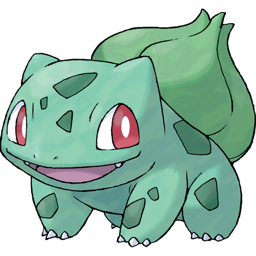

In [3]:
sample['image'].resize((256, 256))

In [4]:
sample["text"]

'a drawing of a green pokemon with red eyes'

Формат к которому необходимо привести датасет

```
{
'image':Pillow.Image,
'text':promt_text
}
```

Взглянем на наш датасет с `object detection`  в  формат COCO. И пройдемся по алгоритму создания элемента датасета для обучения StableDiffusion 

In [5]:
import random

from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from tools import image_grid

Загружаем COCO датасет

In [6]:
ann_file = '../dataset/test/result.json'
dataset_path = '../dataset/test/img'

In [7]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Смотрим какие категории у нас есть

In [8]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print(f'COCO Категории: {nms}')

COCO Категории: ['crack', 'fistula', 'rupture']


Выберем первый класс и посмотрим на изображение с разметкой

In [9]:
catIds = coco.getCatIds(catNms=[nms[0]])

imgIds = coco.getImgIds(catIds=catIds)
print(f'Id изображений с выбранной категорией: {imgIds}')

Id изображений с выбранной категорией: [2, 3, 4, 5, 6, 7, 8, 9]


Такое изображение нашлось, отобразим его и посмотрим на разметку

In [10]:
imgId = imgIds[6]

In [11]:
img = coco.loadImgs(imgId)[0]
img

{'width': 960,
 'height': 1280,
 'id': 8,
 'file_name': '/app/dataset/test/img/239_7_8984.jpg'}

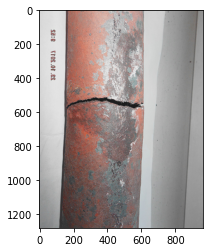

In [12]:
im = Image.open(img['file_name'])
plt.imshow(im)

anns=[{'id': 11, 'image_id': 8, 'category_id': 0, 'segmentation': [], 'bbox': [162, 494, 463, 115], 'ignore': 0, 'iscrowd': 0, 'area': 53245}]


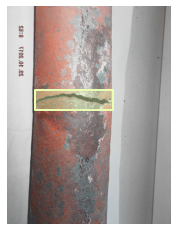

In [13]:
plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print(f'anns={anns}')
coco.showAnns(anns, draw_bbox=True)

Посмотрим на ббоксы

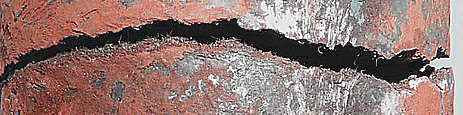

In [14]:
deffects = []
for ann in anns:
    x, y, w, h = [int(x) for x in ann['bbox']]
    im = Image.open(coco.loadImgs(ids=[imgId])[0]['file_name'])
    im_np = np.array(im)[y:y+h, x:x+w]
    deffects.append(Image.fromarray(im_np))
    
image_grid(deffects, 1, len(deffects))

Поскольку StableDiffusion обучается на 512х512, приведем ббоксы к формату 1:1

In [15]:
orig_w, orig_h = im.size
print(f'Исходный размер изображения: {(orig_w, orig_h)}')
# padding_w, padding_h = int(orig_w * SCALE_PADDING_PERCENT), int(orig_h * SCALE_PADDING_PERCENT)
# print(f'Отступы по ширине/высоте {(padding_w, padding_h)}')

Исходный размер изображения: (960, 1280)


In [16]:
x, y, w, h = anns[0]['bbox']
print(f'Исходный ббокс: {(x, y, w, h)}')
center_point = (x + w // 2, y + h // 2)
print(f'Центр ббокса {center_point}')

max_side = max(w,h)
print(f'Максимальная сторона {max_side}')

delta_w, delta_h = max_side - w, max_side - h
print(f'отступ по ширине|длине = {delta_w}|{delta_h}')


new_x =  x - delta_w // 2
new_y = y - delta_h // 2

if new_x < 0:
    max_side += new_x
    new_x = 0
    
if new_y < 0:
    max_side += new_y
    new_y = 0

residual_w, residual_h = (0,0)
if new_x + max_side > orig_w:
    residual_w = new_x + max_side - orig_w
if new_y + max_side > orig_h:
    residual_h = new_y + max_side - orig_h

residual = max(residual_w, residual_h)
max_side -= residual

square_bbox = [
    new_x,
    new_y,
    max_side,
    max_side
]
print(f'квадратный ббокс = {square_bbox}')


Исходный ббокс: (162, 494, 463, 115)
Центр ббокса (393, 551)
Максимальная сторона 463
отступ по ширине|длине = 0|348
квадратный ббокс = [162, 320, 463, 463]


In [17]:
anns

[{'id': 11,
  'image_id': 8,
  'category_id': 0,
  'segmentation': [],
  'bbox': [162, 494, 463, 115],
  'ignore': 0,
  'iscrowd': 0,
  'area': 53245}]

In [18]:
anns[0]['bbox'] = square_bbox
anns[0]['area'] = square_bbox[2] * square_bbox[3]
anns

[{'id': 11,
  'image_id': 8,
  'category_id': 0,
  'segmentation': [],
  'bbox': [162, 320, 463, 463],
  'ignore': 0,
  'iscrowd': 0,
  'area': 214369}]

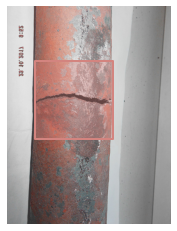

In [19]:
plt.imshow(im); plt.axis('off')
coco.showAnns(anns, draw_bbox=True)

Поскольку StableDiffusion зависит от контекста, то увеличим область ббокса (если это возможно)

In [20]:
SCALE_PADDING_PERCENT = 0.2
square_bbox_with_padding = None
if (square_bbox[2] == orig_w or square_bbox[3] == orig_h):
    square_bbox_with_padding = square_bbox
else:
    padding = int(max_side * SCALE_PADDING_PERCENT)
    print(f'padding={padding}')
    square_bbox_with_padding = [
        square_bbox[0] - padding,
        square_bbox[1] - padding,
        square_bbox[2] + padding * 2,
        square_bbox[3] + padding * 2
    ]
    
    #Проверяем увеличенный ббокс на выход за границы изображения
    x1, y1 = (square_bbox_with_padding[0], square_bbox_with_padding[1])
    x2, y2 = (x1 + square_bbox_with_padding[2], y1 + square_bbox_with_padding[3])
    
    # если ббокс и так большой, то нет смысла его увеличивать и оставляем как есть
    if x2 - x1 > orig_w or y2 - y1 > orig_h:
        square_bbox_with_padding = square_bbox.copy()
    else:
        new_offset_x = 0
        new_offset_y = 0

        if x2 > orig_w:
            print('x2 > orig_w')
            new_offset_x = orig_w - x2
        if y2 > orig_h:
            print('y2 > orig_h')
            new_offset_y = orig_h - y2
        if x1 < 0:
            print('x1 < 0')
            new_offset_x = -x1
        if y1 < 0:
            print('y1 < 0')
            new_offset_y = -y1


        x1 += new_offset_x
        y1 += new_offset_y

        print(x1, y1)
        print(new_offset_x, new_offset_y)

        square_bbox_with_padding[0] = x1
        square_bbox_with_padding[1] = y1

print(f'square_bbox_with_padding={square_bbox_with_padding}')

padding=92
70 228
0 0
square_bbox_with_padding=[70, 228, 647, 647]


In [21]:
anns[0]['bbox'] = square_bbox_with_padding
anns[0]['area'] = square_bbox_with_padding[2]*square_bbox_with_padding[3]
anns

[{'id': 11,
  'image_id': 8,
  'category_id': 0,
  'segmentation': [],
  'bbox': [70, 228, 647, 647],
  'ignore': 0,
  'iscrowd': 0,
  'area': 418609}]

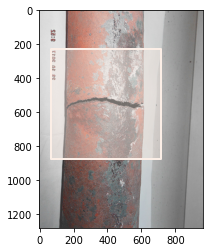

In [22]:
plt.imshow(im); plt.axis('on')
coco.showAnns(anns, draw_bbox=True)

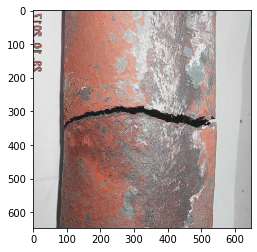

In [23]:
im_np = np.array(im)[ anns[0]['bbox'][1] : anns[0]['bbox'][1] + anns[0]['bbox'][3], anns[0]['bbox'][0] : anns[0]['bbox'][0] + anns[0]['bbox'][2] ]
curr_img = Image.fromarray(im_np)
plt.imshow(curr_img)

Далее нужно сгенерировать промпт для получившегося изображения

In [24]:
labelid2text = {0:'crack', 1:'fistula', 2:'rupture'} # Конвертация id класса в название

PROMT_TEMAPLTE = [
    'photo of a <OBJ> on a metal pipe',
    '<OBJ> on a metal pipe',
    '<OBJ> on a old metal pipe',
    'corrosion <OBJ> on a metal pipe',
    'corrosion <OBJ> on a old metal pipe',
    '<OBJ> on a rusty metal pipe'
]

def generate_promt(obj:str):
    return random.choice(PROMT_TEMAPLTE).replace('<OBJ>', obj)

In [25]:
test_dataset = []

generated_promt = generate_promt(labelid2text[anns[0]['category_id']])

test_dataset.append({
    'text': generated_promt,
    'image': curr_img
})

In [26]:
test_dataset

[{'text': 'crack on a old metal pipe',
  'image': <PIL.Image.Image image mode=RGB size=647x647 at 0x7F349227B910>}]

# Создание Датасета для файнтюнинга

In [27]:
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

In [28]:
ann_file = '/app/dataset/test/result.json'
dataset_path = '/app/dataset/test/img'

In [29]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [30]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO Категории: \n{}'.format(' '.join(nms)))

COCO Категории: 
crack fistula rupture


In [31]:
labelid2text = {}
for el in [cat for cat in cats]:
    labelid2text[el['id']] = el['name']
    
PROMT_TEMAPLTE = [
    'photo of a <OBJ> on a metal pipe',
    '<OBJ> on a metal pipe',
    '<OBJ> on a old metal pipe',
    'corrosion <OBJ> on a metal pipe',
    'corrosion <OBJ> on a old metal pipe',
    '<OBJ> on a rusty metal pipe'
]

SCALE_PADDING_PERCENT = 0.2

def generate_promt(obj:str):
    return random.choice(PROMT_TEMAPLTE).replace('<OBJ>', obj)

In [32]:
new_dataset = []
imgs = coco.imgs
imgs = list(imgs.values())
for img in tqdm(imgs):
    ann_id = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    ann_img = coco.loadAnns(ann_id)
    img_path = img["file_name"].replace("\\", "/") # делаем замену windows на linux пути
    img_orig = Image.open(f"{img_path}")
    orig_w, orig_h = img_orig.size
    
    for ann in ann_img:
        x, y, w, h = ann['bbox']
        #делаем квадраьный ббокс
        center_point = (x + w // 2, y + h // 2)
        max_side = max(w,h)
        delta_w, delta_h = max_side - w, max_side - h
        new_x =  x - delta_w // 2
        new_y = y - delta_h // 2
        if new_x < 0:
            max_side += new_x
            new_x = 0
        if new_y < 0:
            max_side += new_y
            new_y = 0
        residual_w, residual_h = (0,0)
        if new_x + max_side > orig_w:
            residual_w = new_x + max_side - orig_w
        if new_y + max_side > orig_h:
            residual_h = new_y + max_side - orig_h
        residual = max(residual_w, residual_h)
        max_side -= residual
        square_bbox = [
            new_x,
            new_y,
            max_side,
            max_side
        ]
        #увеличиваем квадратный ббокс
        square_bbox_with_padding = None
        if (square_bbox[2] == orig_w or square_bbox[3] == orig_h):
            square_bbox_with_padding = square_bbox
        else:
            padding = int(max_side * SCALE_PADDING_PERCENT)
            square_bbox_with_padding = [
                square_bbox[0] - padding,
                square_bbox[1] - padding,
                square_bbox[2] + padding * 2,
                square_bbox[3] + padding * 2
            ]
            #Проверяем увеличенный ббокс на выход за границы изображения
            x1, y1 = (square_bbox_with_padding[0], square_bbox_with_padding[1])
            x2, y2 = (x1 + square_bbox_with_padding[2], y1 + square_bbox_with_padding[3])
            # если ббокс и так большой, то нет смысла его увеличивать и оставляем как есть
            if x2 - x1 > orig_w or y2 - y1 > orig_h:
                square_bbox_with_padding = square_bbox.copy()
            else:
                new_offset_x = 0
                new_offset_y = 0
                if x2 > orig_w:
                    new_offset_x = orig_w - x2
                if y2 > orig_h:
                    new_offset_y = orig_h - y2
                if x1 < 0:
                    new_offset_x = -x1
                if y1 < 0:
                    new_offset_y = -y1
                x1 += new_offset_x
                y1 += new_offset_y
                square_bbox_with_padding[0] = x1
                square_bbox_with_padding[1] = y1
        #Обрезаем исходное изображение по полученному ббоксу
        crop_x1, crop_y1 = square_bbox_with_padding[0], square_bbox_with_padding[1]
        crop_x2, crop_y2 = crop_x1 + square_bbox_with_padding[2], crop_y1 + square_bbox_with_padding[3]
        im_np = np.array(img_orig)[ crop_y1:crop_y2, crop_x1:crop_x2]
        cr_img = Image.fromarray(im_np)
        #генерируем промпт
        generated_promt = generate_promt(labelid2text[ann['category_id']])
        #добавляем изображение и промпт в датасет
        new_dataset.append({
            'text': generated_promt,
            'image': cr_img
        })

100%|██████████| 10/10 [00:00<00:00, 12.15it/s]


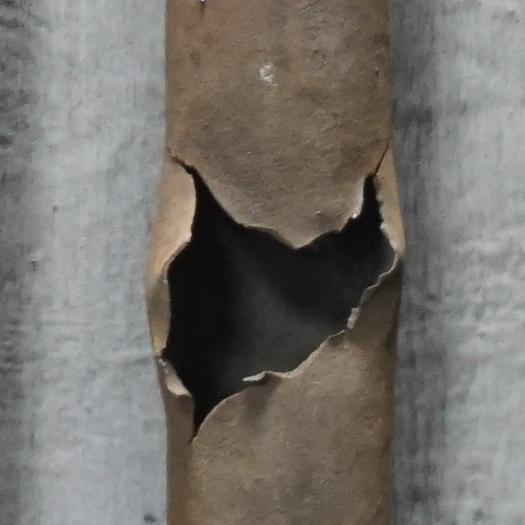

In [33]:
new_dataset[2]['image']

In [34]:
new_dataset[2]['text']

'corrosion rupture on a metal pipe'

# Сохраняем датасет

In [35]:
from datasets import Dataset
path_to_save_dataset = '/app/dataset/promt_datasets'
dataset = Dataset.from_list(new_dataset) # Загрузим датасет из списка в объект 

dataset.save_to_disk(path_to_save_dataset) # Сохраним датасет на диск 

Saving the dataset (0/1 shards):   0%|          | 0/13 [00:00<?, ? examples/s]

In [36]:
new_dataset = Dataset.load_from_disk(path_to_save_dataset)
len(new_dataset)

13

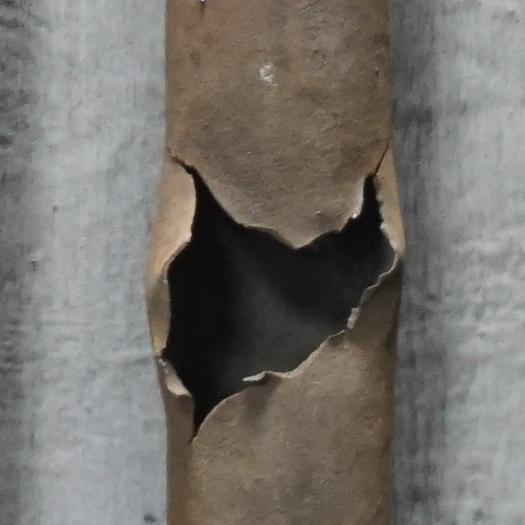

In [37]:
new_dataset[2]['image']

In [38]:
new_dataset[2]['text']

'corrosion rupture on a metal pipe'